# Prompt Generator

In this example we will create a chat bot that helps a user generate a prompt.
It will first collect requirements from the user, and then will generate the prompt (and refine it based on user input).
These are split into two separate states, and the LLM decides when to transition between them.

A graphical representation of the system can be found below.

![](imgs/prompt-generator.png)

## Gather information

First, let's define the part of the graph that will gather user requirements. This will be an LLM call with a specific system message. It will have access to a tool that it can call when it is ready to generate the prompt.

In [1]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

In [2]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

chain = get_messages_info | llm_with_tool

## Generate Prompt

We now set up the state that will generate the prompt.
This will require a separate system message, as well as a function to filter out all message PRIOR to the tool invocation (as that is when the previous state decided it was time to generate the prompt

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


prompt_gen_chain = get_prompt_messages | llm

## Define the state logic

This is the logic for what state the chatbot is in.
If the last message is a tool call, then we are in the state where the "prompt creator" (`prompt`) should respond.
Otherwise, if the last message is not a HumanMessage, then we know the human should respond next and so we are in the `END` state.
If the last message is a HumanMessage, then if there was a tool call previously we are in the `prompt` state.
Otherwise, we are in the "info gathering" (`info`) state.

In [ ]:
from typing import Literal

from langgraph.graph import END


def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

## Create the graph

We can now the create the graph.
We will use a SqliteSaver to persist conversation history.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, MessageGraph

memory = SqliteSaver.from_conn_string(":memory:")
workflow = MessageGraph()
workflow.add_node("info", chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Prompt generated!", tool_call_id=state[-1].tool_calls[0]["id"]
    )


workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

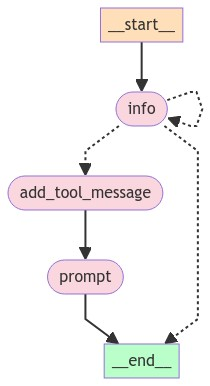

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Use the graph

We can now use the created chatbot.

In [41]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        [HumanMessage(content=user)], config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

Hello! How can I assist you today?
================================== Ai Message ==================================

Sure! I can help you with that. To create an extraction prompt, I need some information from you. Could you please provide the following details:

1. What is the objective of the prompt?
2. What variables will be passed into the prompt template?
3. Any constraints for what the output should NOT do?
4. Any requirements that the output MUST adhere to?

Once I have this information, I can create the extraction prompt for you.
================================== Ai Message ==================================

Great! To create an extraction prompt for filling out a CSAT (Customer Satisfaction) survey, I will need the following information:

1. Objective: To gather feedback on customer satisfaction.
2. Variables: Customer name, Date of interaction, Service provided, Rating (scale of 1-5), Comments.